In [2]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Proje kökü: .../codes/server
PROJECT_ROOT = Path("..").resolve()
SRC_DIR = PROJECT_ROOT / "src"

# src klasörünü Python path'e ekle
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from data_loading import load_clean_data, TICKERS
import features
import models_baseline

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

PROJECT_ROOT, SRC_DIR, TICKERS

(PosixPath('/Users/omerfsaribal/Uni/5th-Term/FinTech/Project/wealthflow/python-server/server'),
 PosixPath('/Users/omerfsaribal/Uni/5th-Term/FinTech/Project/wealthflow/python-server/server/src'),
 ['AAPL', 'MSFT', 'SPY', 'QQQ', 'TLT', 'GLD'])

In [3]:
TICKERS

['AAPL', 'MSFT', 'SPY', 'QQQ', 'TLT', 'GLD']

In [4]:
df_aapl = load_clean_data("AAPL")
df_aapl.head()

,Date,Close,Open,High,Low,Volume,Change
0,2015-01-02,27.33,27.85,27.86,26.84,212820000.0,-0.0095
1,2015-01-05,26.56,27.07,27.16,26.35,257140000.0,-0.0282
2,2015-01-06,26.57,26.64,26.86,26.16,263190000.0,0.0000
3,2015-01-07,26.94,26.80,27.05,26.67,160420000.0,0.0140
4,2015-01-08,27.97,27.31,28.04,27.17,237460000.0,0.0384


In [5]:
df_aapl.dtypes

Date      datetime64[ns]
Close            float64
Open             float64
High             float64
Low              float64
Volume           float64
Change           float64
dtype: object

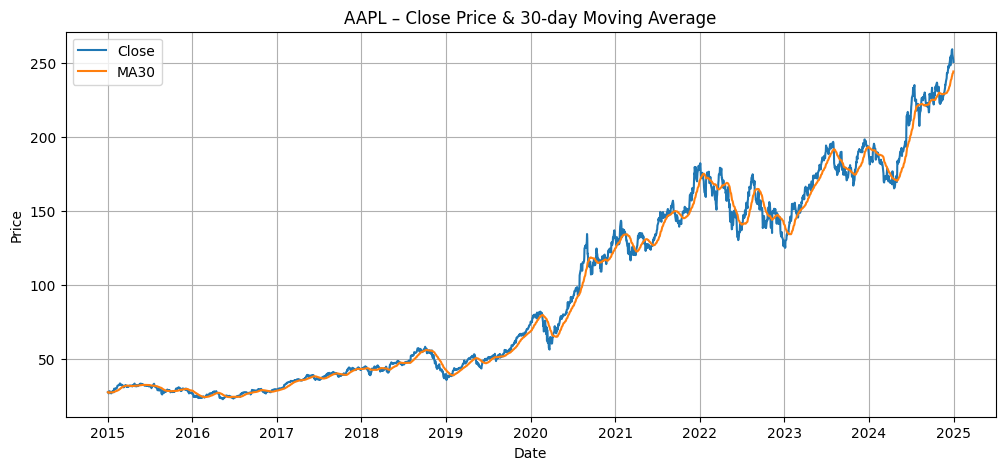

In [6]:
df_aapl = df_aapl.copy()
df_aapl["MA30"] = features.compute_moving_average(df_aapl, window=30)

plt.figure(figsize=(12, 5))
plt.plot(df_aapl["Date"], df_aapl["Close"], label="Close")
plt.plot(df_aapl["Date"], df_aapl["MA30"], label="MA30")
plt.title("AAPL – Close Price & 30-day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [7]:
asset_stats = features.compute_all_assets_metrics()
asset_stats_df = pd.DataFrame(asset_stats).T  # tickers as index
asset_stats_df

,annual_return,annual_volatility,sharpe
AAPL,0.262582,0.284734,0.922204
MSFT,0.257156,0.271520,0.947100
SPY,0.120546,0.176770,0.681937
QQQ,0.184520,0.218279,0.845343
TLT,-0.026037,0.153250,-0.169901
GLD,0.084516,0.140485,0.601597


In [8]:
returns_dict = features.compute_all_daily_returns()
corr = features.compute_correlation_matrix(returns_dict)

corr

,AAPL,MSFT,SPY,QQQ,TLT,GLD
AAPL,1.000000,-0.004468,0.511830,0.002329,-0.132094,-0.034169
MSFT,-0.004468,1.000000,-0.043635,0.860857,0.057343,-0.030445
SPY,0.511830,-0.043635,1.000000,-0.030027,-0.224221,-0.022280
QQQ,0.002329,0.860857,-0.030027,1.000000,0.030849,-0.016932
TLT,-0.132094,0.057343,-0.224221,0.030849,1.000000,0.165863
GLD,-0.034169,-0.030445,-0.022280,-0.016932,0.165863,1.000000


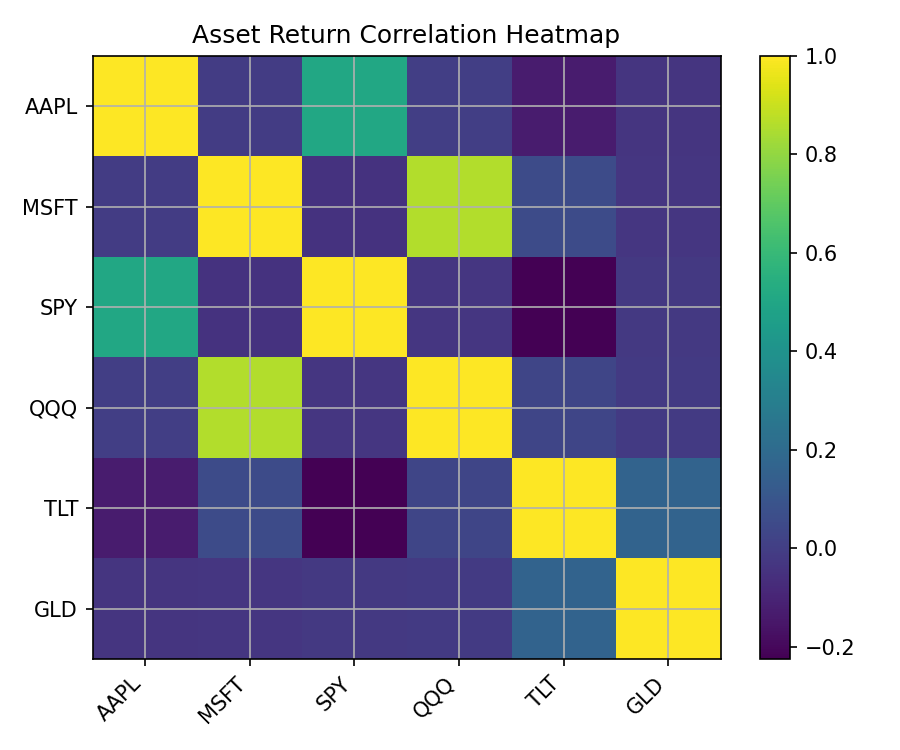

In [9]:
features.plot_correlation_heatmap(corr)

from IPython.display import Image, display

heatmap_path = PROJECT_ROOT / "outputs" / "figures" / "correlation_heatmap.png"
display(Image(filename=str(heatmap_path)))

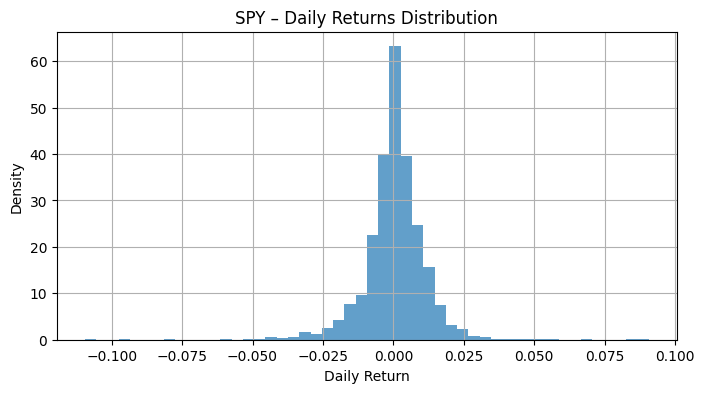

In [10]:
rets_spy = returns_dict["SPY"].dropna()

plt.figure(figsize=(8, 4))
plt.hist(rets_spy, bins=50, density=True, alpha=0.7)
plt.title("SPY – Daily Returns Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.show()

In [11]:
# Clean SPY prices
df_spy = load_clean_data("SPY").copy()
df_spy = df_spy.set_index("Date")
price_spy = df_spy["Close"]

# Naive ve MA(30) forecast örneği
horizon = 30

naive_forecast = models_baseline.naive_forecast_last_value(price_spy, horizon=horizon)
ma_forecast = models_baseline.moving_average_forecast(price_spy, window=30, horizon=horizon)

naive_forecast[:5], ma_forecast[:5]

(array([586.08, 586.08, 586.08, 586.08, 586.08]),
 array([598.403, 598.403, 598.403, 598.403, 598.403]))

In [12]:
exp_ret_30d_spy = models_baseline.compute_expected_return_30d_from_history(price_spy)
exp_vol_30d_spy = models_baseline.compute_expected_vol_30d_from_history(price_spy)

exp_ret_30d_spy, exp_vol_30d_spy

(0.012239696187986149, 0.04352175223750672)

In [24]:
desc_stats_df = features.compute_descriptive_stats_for_returns(returns_dict)
desc_stats_df

,mean,median,std,min,max,skewness,kurtosis
ticker,,,,,,,
AAPL,0.001042,0.000863,0.017937,-0.128652,0.119723,0.000833,5.302097
MSFT,0.001020,0.000908,0.017104,-0.147390,0.142169,0.079670,7.794617
SPY,0.000478,0.000570,0.011135,-0.109424,0.090603,-0.554892,12.590885
QQQ,0.000732,0.001163,0.013750,-0.119798,0.084692,-0.377545,6.268746
TLT,-0.000103,0.000295,0.009654,-0.066683,0.075196,0.097184,4.512372
GLD,0.000335,0.000394,0.008850,-0.053694,0.049122,-0.104469,2.811748


In [14]:
baseline_forecasts = models_baseline.build_baseline_forecasts()
baseline_df = pd.DataFrame(baseline_forecasts).T

baseline_df

,expected_return_30d,expected_vol_30d
AAPL,0.051300,0.059158
MSFT,0.009241,0.074093
SPY,0.012240,0.043522
QQQ,0.025732,0.059912
TLT,-0.043648,0.051298
GLD,-0.004292,0.056844


In [15]:
missing_report = features.compute_missing_report()
missing_df = pd.DataFrame(missing_report).T  
missing_df

,Date,Close,Open,High,Low,Volume,Change
AAPL,0,0,0,0,0,0,0
MSFT,0,0,0,0,0,0,0
SPY,0,0,0,0,0,5,0
QQQ,0,0,0,0,0,0,0
TLT,0,0,0,0,0,0,0
GLD,0,0,0,0,0,26,0


In [16]:
outlier_report = features.compute_outlier_report(returns_dict)
outlier_df = pd.DataFrame(outlier_report).T
outlier_df

,lower_bound,upper_bound,outlier_count,total_count,outlier_ratio
AAPL,-0.033549,0.036191,139.0,2515.0,0.055268
MSFT,-0.031664,0.034610,132.0,2516.0,0.052464
SPY,-0.018322,0.020457,168.0,2520.0,0.066667
QQQ,-0.024546,0.027261,169.0,2516.0,0.067170
TLT,-0.022944,0.022563,60.0,2515.0,0.023857
GLD,-0.018978,0.019442,97.0,2541.0,0.038174


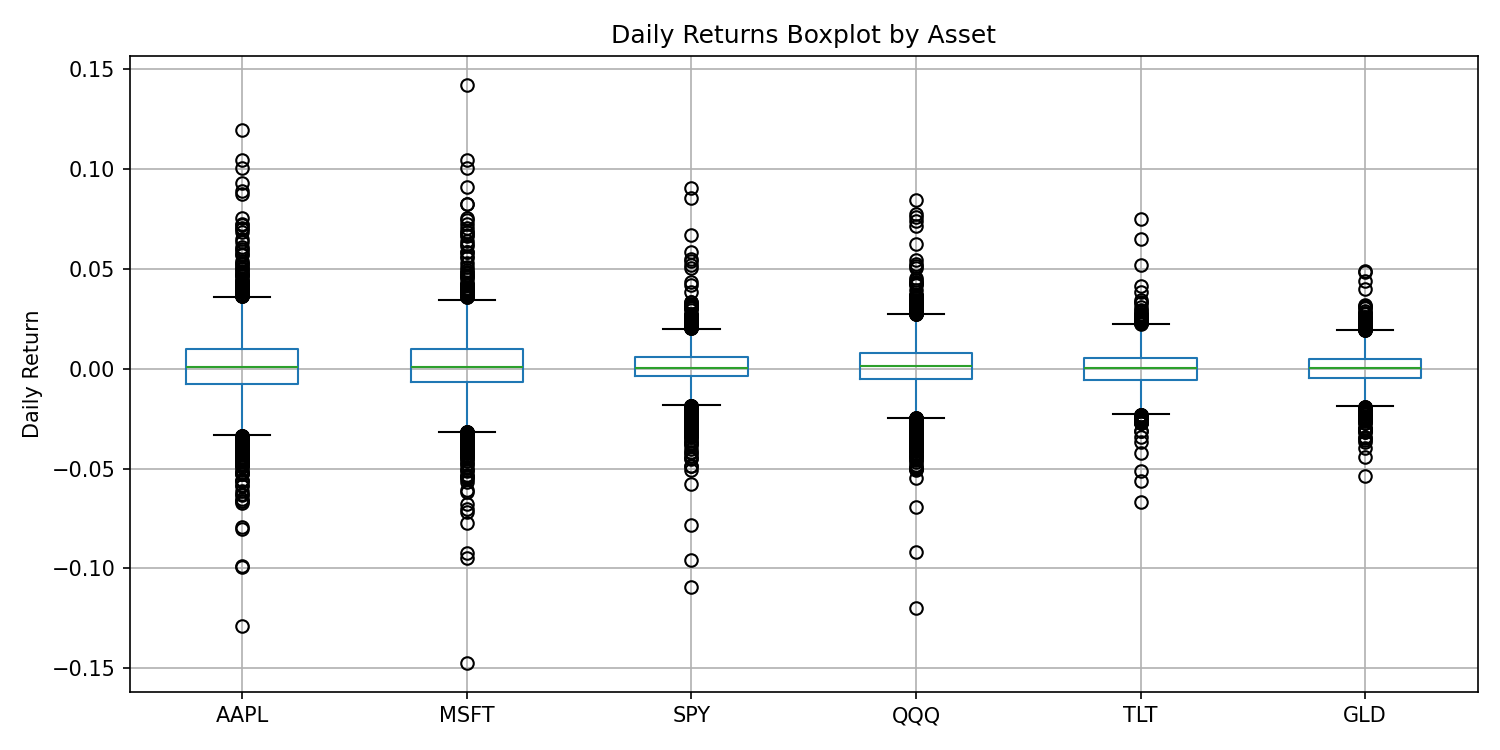

In [17]:
features.plot_returns_boxplots(returns_dict)

from IPython.display import Image, display

boxplot_path = PROJECT_ROOT / "outputs" / "figures" / "returns_boxplot_all.png"
display(Image(filename=str(boxplot_path)))

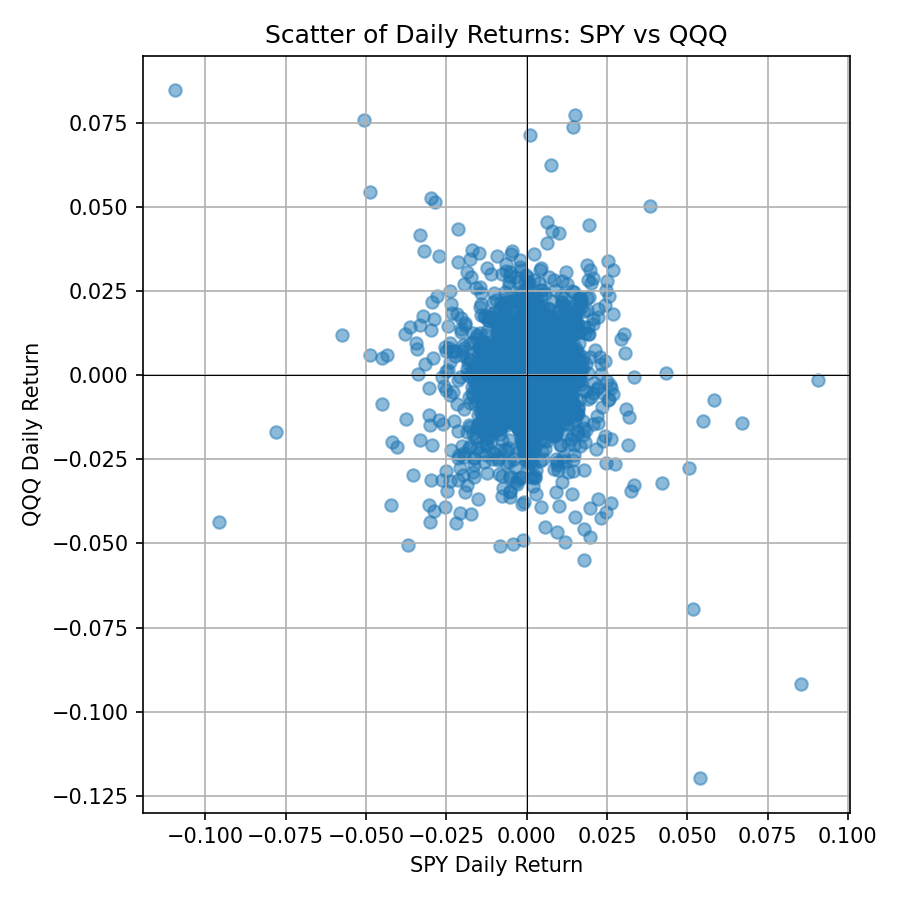

In [18]:
features.plot_scatter_returns(returns_dict, x_ticker="SPY", y_ticker="QQQ")

scatter_path = PROJECT_ROOT / "outputs" / "figures" / "scatter_SPY_QQQ_returns.png"
display(Image(filename=str(scatter_path)))

In [19]:
df_spy = load_clean_data("SPY").copy()
df_spy = df_spy.set_index("Date")
price_spy = df_spy["Close"].astype(float)

horizon = 30

naive_forecast = models_baseline.naive_forecast_last_value(price_spy, horizon=horizon)
ma_forecast = models_baseline.moving_average_forecast(price_spy, window=30, horizon=horizon)

naive_forecast[:5], ma_forecast[:5]

(array([586.08, 586.08, 586.08, 586.08, 586.08]),
 array([598.403, 598.403, 598.403, 598.403, 598.403]))

In [20]:
exp_ret_30d_spy = models_baseline.compute_expected_return_30d_from_history(price_spy)
exp_vol_30d_spy = models_baseline.compute_expected_vol_30d_from_history(price_spy)

exp_ret_30d_spy, exp_vol_30d_spy

(0.012239696187986149, 0.04352175223750672)

In [21]:
baseline_forecasts = models_baseline.build_baseline_forecasts()
baseline_df = pd.DataFrame(baseline_forecasts).T
baseline_df

,expected_return_30d,expected_vol_30d
AAPL,0.051300,0.059158
MSFT,0.009241,0.074093
SPY,0.012240,0.043522
QQQ,0.025732,0.059912
TLT,-0.043648,0.051298
GLD,-0.004292,0.056844


In [22]:
import json

forecasts_path = PROJECT_ROOT / "outputs" / "json" / "forecasts_baseline.json"

with forecasts_path.open() as f:
    forecasts_from_file = json.load(f)

forecasts_from_file["SPY"]

{'expected_return_30d': 0.012239696187986149,
 'expected_vol_30d': 0.04352175223750672}

In [23]:
from pathlib import Path
import json

json_path = Path("../outputs/json/forecasts_baseline.json")
with json_path.open() as f:
    forecasts_from_file = json.load(f)

forecasts_from_file["SPY"]

{'expected_return_30d': 0.012239696187986149,
 'expected_vol_30d': 0.04352175223750672}